# Initialize the accelerator

In [1]:
from finn_examples import models
print(list(filter(lambda x: "imagenet" in x, dir(models))))

['_imagenet_resnet50_top5inds_io_shape_dict', '_imagenet_top5inds_io_shape_dict', 'mobilenetv1_w4a4_imagenet', 'resnet50_w1a2_imagenet']


In [2]:
#mobilenetv1_w4a4 is available on U250 and ZCU104
#accel = models.mobilenetv1_w4a4_imagenet()
#resnet50_w1a2 is available on U250 only
accel = models.resnet50_w1a2_imagenet()
#some systems with custom builds might require a manual platform setting:
#accel = models.mobilenetv1_w4a4_imagenet("ZCU102")

In [3]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal()), str(accel.idt())))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal()), str(accel.odt())))

Expected input shape and datatype: (1, 224, 224, 3) UINT8
Expected output shape and datatype: (1, 5) UINT16


# Prepare loading of ImageNet validation dataset

In [ ]:
import numpy as np
from PIL import Image
from dataset_loading import FileQueue, ImgQueue
import os

# 2 ways to provide the data:
# without a label file: expect images in 1000 sorted subfolders
# with a label file: expect images directly in val directory
val_dir = os.environ["IMAGENET_VAL_PATH"]
label_file = None
print(val_dir)

In [5]:
def img_resize(img, size):
    w, h = img.size
    if (w <= h and w == size) or (h <= w and h == size):
        return img
    if w < h:
        ow = size
        oh = int(size * h / w)
        return img.resize((ow, oh), Image.BILINEAR)
    else:
        oh = size
        ow = int(size * w / h)
        return img.resize((ow, oh), Image.BILINEAR)

def img_center_crop(img, size):
    crop_height, crop_width = (size, size)
    image_width, image_height = img.size
    crop_top = int(round((image_height - crop_height) / 2.))
    crop_left = int(round((image_width - crop_width) / 2.))
    return img.crop((crop_left, crop_top, crop_left + crop_width, crop_top + crop_height))

def pre_process(img_np):
    img = Image.fromarray(img_np.astype(np.uint8))
    img = img_resize(img, 256)
    img = img_center_crop(img, 224)
    img = np.array(img, dtype=np.uint8)
    return img

def setup_dataloader(val_path, label_file_path = None, batch_size=100, n_images = 50000):
    if label_file_path is None:
        val_folders = [ f.name for f in os.scandir(val_path) if f.is_dir() ]
        val_folders = sorted(val_folders)
        assert len(val_folders) == 1000, "Expected 1000 subfolders in ILSVRC2012 val"
        files = []
        labels = []
        for idx, folder in enumerate(val_folders):
            current_files = sorted(os.listdir(os.path.join(val_path, folder)))
            current_files = [os.path.join(folder, file) for file in current_files]
            files.extend(current_files)
            labels.extend([idx]*len(current_files))
        files = files[:n_images]
    else:
        files = ['ILSVRC2012_val_{:08d}.JPEG'.format(i) for i in range(1,n_images+1)]
        labels = np.loadtxt(label_file_path, dtype=int, usecols=1)

    file_queue = FileQueue()
    file_queue.load_epochs(list(zip(files,labels)), shuffle=False)
    img_queue = ImgQueue(maxsize=batch_size)
    img_queue.start_loaders(file_queue, num_threads=4, img_dir=val_path, transform=pre_process)
    return img_queue

# Classify a single image

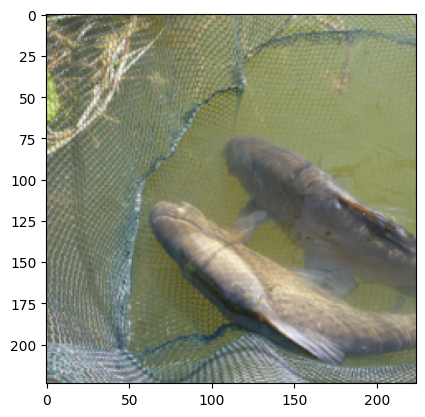

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

img_queue = setup_dataloader(val_dir, label_file, 1, 1)

test_single_x, test_single_y = img_queue.get()

plt.imshow(test_single_x)
plt.show()

In [7]:
test_single_y

0

In [8]:
accel_in = test_single_x.reshape(accel.ishape_normal())
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 224, 224, 3) and datatype is uint8


In [9]:
accel_out = accel.execute(accel_in)

In [10]:
print("Top-5 classes predicted by the accelerator: " + str(accel_out))

Top-5 classes predicted by the accelerator: [[  0. 390.  48. 391. 150.]]


In [11]:
%%timeit
accel_out = accel.execute(accel_in)

24.3 ms ± 85 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Validate accuracy on entire ImageNet validation set

In [12]:
batch_size = 100
accel.batch_size = batch_size
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed()), str(accel.oshape_packed())))

Accelerator buffer shapes are (100, 224, 224, 1, 3) for input, (100, 5, 2) for output


In [13]:
img_queue = setup_dataloader(val_dir, label_file, batch_size)

ok = 0
nok = 0
i = 0
while not img_queue.last_batch:
    imgs, lbls = img_queue.get_batch(batch_size, timeout=None)
    imgs = np.array(imgs)
    exp = np.array(lbls)
    
    ibuf_normal = imgs.reshape(accel.ishape_normal())
    obuf_normal = accel.execute(ibuf_normal)
    obuf_normal = obuf_normal.reshape(batch_size, -1)[:,0]
    ret = np.bincount(obuf_normal.flatten() == exp.flatten())
    nok += ret[0]
    ok += ret[1]
    i += 1
    print("batch %d : total OK %d NOK %d" % (i, ok, nok))

batch 1 : total OK 88 NOK 12
batch 2 : total OK 160 NOK 40
batch 3 : total OK 238 NOK 62
batch 4 : total OK 303 NOK 97
batch 5 : total OK 393 NOK 107
batch 6 : total OK 485 NOK 115
batch 7 : total OK 579 NOK 121
batch 8 : total OK 665 NOK 135
batch 9 : total OK 754 NOK 146
batch 10 : total OK 842 NOK 158
batch 11 : total OK 919 NOK 181
batch 12 : total OK 1008 NOK 192
batch 13 : total OK 1101 NOK 199
batch 14 : total OK 1167 NOK 233
batch 15 : total OK 1252 NOK 248
batch 16 : total OK 1332 NOK 268
batch 17 : total OK 1385 NOK 315
batch 18 : total OK 1438 NOK 362
batch 19 : total OK 1511 NOK 389
batch 20 : total OK 1585 NOK 415
batch 21 : total OK 1644 NOK 456
batch 22 : total OK 1720 NOK 480
batch 23 : total OK 1787 NOK 513
batch 24 : total OK 1848 NOK 552
batch 25 : total OK 1925 NOK 575
batch 26 : total OK 2003 NOK 597
batch 27 : total OK 2079 NOK 621
batch 28 : total OK 2136 NOK 664
batch 29 : total OK 2221 NOK 679
batch 30 : total OK 2282 NOK 718
batch 31 : total OK 2335 NOK 765
ba

batch 237 : total OK 17233 NOK 6467
batch 238 : total OK 17315 NOK 6485
batch 239 : total OK 17389 NOK 6511
batch 240 : total OK 17429 NOK 6571
batch 241 : total OK 17484 NOK 6616
batch 242 : total OK 17538 NOK 6662
batch 243 : total OK 17592 NOK 6708
batch 244 : total OK 17668 NOK 6732
batch 245 : total OK 17707 NOK 6793
batch 246 : total OK 17785 NOK 6815
batch 247 : total OK 17832 NOK 6868
batch 248 : total OK 17895 NOK 6905
batch 249 : total OK 17969 NOK 6931
batch 250 : total OK 18008 NOK 6992
batch 251 : total OK 18064 NOK 7036
batch 252 : total OK 18116 NOK 7084
batch 253 : total OK 18165 NOK 7135
batch 254 : total OK 18231 NOK 7169
batch 255 : total OK 18292 NOK 7208
batch 256 : total OK 18366 NOK 7234
batch 257 : total OK 18433 NOK 7267
batch 258 : total OK 18489 NOK 7311
batch 259 : total OK 18537 NOK 7363
batch 260 : total OK 18611 NOK 7389
batch 261 : total OK 18679 NOK 7421
batch 262 : total OK 18735 NOK 7465
batch 263 : total OK 18795 NOK 7505
batch 264 : total OK 18849 N

batch 462 : total OK 31311 NOK 14889
batch 463 : total OK 31380 NOK 14920
batch 464 : total OK 31461 NOK 14939
batch 465 : total OK 31521 NOK 14979
batch 466 : total OK 31576 NOK 15024
batch 467 : total OK 31650 NOK 15050
batch 468 : total OK 31721 NOK 15079
batch 469 : total OK 31808 NOK 15092
batch 470 : total OK 31883 NOK 15117
batch 471 : total OK 31958 NOK 15142
batch 472 : total OK 32018 NOK 15182
batch 473 : total OK 32101 NOK 15199
batch 474 : total OK 32165 NOK 15235
batch 475 : total OK 32234 NOK 15266
batch 476 : total OK 32308 NOK 15292
batch 477 : total OK 32393 NOK 15307
batch 478 : total OK 32479 NOK 15321
batch 479 : total OK 32561 NOK 15339
batch 480 : total OK 32641 NOK 15359
batch 481 : total OK 32680 NOK 15420
batch 482 : total OK 32744 NOK 15456
batch 483 : total OK 32811 NOK 15489
batch 484 : total OK 32872 NOK 15528
batch 485 : total OK 32910 NOK 15590
batch 486 : total OK 32974 NOK 15626
batch 487 : total OK 33037 NOK 15663
batch 488 : total OK 33102 NOK 15698
b

In [14]:
total = 50000
acc = 100.0 * ok / (total)
print("Final top-1 accuracy: {}%".format(acc))

Final top-1 accuracy: 67.974%


## More benchmarking

In [15]:
accel.throughput_test()

{'runtime[ms]': 539.1037464141846,
 'throughput[images/s]': 185.49305335966196,
 'DRAM_in_bandwidth[MB/s]': 27.921898336123192,
 'DRAM_out_bandwidth[MB/s]': 0.0018549305335966194,
 'DRAM_extw_idma0_bandwidth[MB/s]': 379.88977328058763,
 'fclk[mhz]': 187,
 'batch_size': 100,
 'fold_input[ms]': 0.026702880859375,
 'pack_input[ms]': 0.030517578125,
 'copy_input_data_to_device[ms]': 4.973411560058594,
 'copy_output_data_from_device[ms]': 0.06866455078125,
 'unpack_output[ms]': 9.851217269897461,
 'unfold_output[ms]': 0.0064373016357421875}